In [91]:
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

cartopy 0.15.1


In [35]:
#grab these from ag1000g - no need to bring in the meta data file
df_lonlat = pd.DataFrame()
df_lonlat['country'] = ['Angola', 'Burkina Faso', 'Cameroon', 'Gabon', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Uganda']
df_lonlat['longitude'] = [13.291000, -4.413900, 13.936844, 9.455000, -9.675065, -15.582000, 39.824614, 34.026000]
df_lonlat['latitude'] = [-8.821000, 11.206500, 4.937851, 0.384000, 8.887097, 11.891000, -3.702068, 0.770000]
df_lonlat = df_lonlat.set_index('country')

In [38]:
#check
df_lonlat.loc['Angola']

longitude    13.291
latitude     -8.821
Name: Angola, dtype: float64

In [40]:
#check
for country, row in df_lonlat.iterrows():
    print(country, row.latitude, row.longitude)

Angola -8.821 13.291
Burkina Faso 11.2065 -4.4139
Cameroon 4.937851 13.936844
Gabon 0.384 9.455
Guinea 8.887097 -9.675065
Guinea-Bissau 11.891 -15.582
Kenya -3.702068 39.824614
Uganda 0.77 34.026


In [41]:
crs_lonlat = ccrs.PlateCarree()

In [88]:
ratios=np.asarray([0.5, 0.5])


In [89]:
sum(ratios)

1.0

/home/chris/Git/agam-vgsc-report/dependencies/miniconda/envs/agam-vgsc-report/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in double_scalars
/home/chris/Git/agam-vgsc-report/dependencies/miniconda/envs/agam-vgsc-report/lib/python3.5/site-packages/matplotlib/markers.py:292: RuntimeWarning: invalid value encountered in absolute
  rescale = max(np.max(np.abs(verts[:, 0])),
/home/chris/Git/agam-vgsc-report/dependencies/miniconda/envs/agam-vgsc-report/lib/python3.5/site-packages/matplotlib/markers.py:293: RuntimeWarning: invalid value encountered in absolute
  np.max(np.abs(verts[:, 1])))


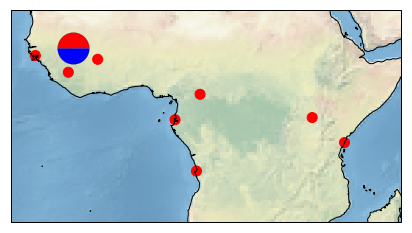

In [99]:
extent_lonlat = (-20, 50, -18, 20)

subplot_kw = dict(projection=crs_lonlat)
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=subplot_kw)
ax.set_extent(extent_lonlat, crs=crs_lonlat)
ax.coastlines(resolution='50m', linewidth=.5)
ax.stock_img()
#ax.add_feature(cfeature.BORDERS, lw=.5)
#ax.add_feature(cfeature.LAKES)
#ax.margins(0)
for country, row in df_lonlat.iterrows():
    ax.add_patch(plt.Circle((row.longitude, row.latitude), radius=.9, color='r'))

draw_pie(ax=ax, ratios=ratios, X=-8.821 , Y=13.291, colors=['r', 'b'], size=1000, offset=(0, 0))

In [75]:
def draw_pie(ax, ratios, X, Y, colors, offset=(-300000, 300000), size=1000, lw=0.2):
    
    N = len(ratios)
    assert ratios.sum() == 1.0, "ratios must sum to 1.0 not %s" % ratios.sum()

    xy = []
    a, b = offset[0]*1e6, offset[1]*1e6
    start = 0.
    ix = list()
    # build xy
    for i, ratio in enumerate(ratios):
        if ratio > 0:
            x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 
                                         int(200*ratio))).tolist()
            y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 
                                         int(200*ratio))).tolist()
            xy1 = list(zip(x,y))
            xy.append(xy1)
            ix.append(i)
            start += ratio

    # if just one segment, then draw a circle.
    if len(xy) == 1:
        ax.scatter([X + a],[Y + b] , marker="o", s=size, 
                   facecolor=colors[ix[0]], linewidths=lw,
                   edgecolor="black", zorder=20)    
    else:
        for idx, xyi in zip(ix, xy):
            ax.scatter([X + a],[Y + b] , marker=(xyi, 0), s=size, alpha=1.0,
                       facecolor=colors[idx], edgecolor="black", linewidths=lw, zorder=20)
    
    
    
    # given the offset, draw a triangle pointed at the origin (0, 0)
    scaledg = np.abs([a, b]).mean()
    grad = a/scaledg, b/scaledg
    hypot = np.sqrt(a**2 + b**2)
    
    A = np.array(grad)
    const = 0.15
    alength = np.sqrt(A[0]**2 + A[1]**2)
    
    B = A * alength * const
    B1 = np.array([-B[1], B[0]])
    B2 = np.array([B[1], -B[0]])
    A1 = A + B1
    A2 = A + B2
        
    pointer = [(0, 0), A1, A2]
    ax.scatter([X], [Y],
               marker=(pointer, 0), 
               s=scaledg/220, facecolor="grey", edgecolor="none", linewidth=0.5, zorder=9)